from [https://github.com/volunt4s/TinyNeRF-pytorch/blob/main/tiny_nerf.py](https://github.com/volunt4s/TinyNeRF-pytorch/blob/main/tiny_nerf.py)


In [39]:
import sys 
sys.path.append('../../')
sys.path.append('../')

import os, sys
# import tensorflow as tf
# tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

import radfoam
import mesh_tools as mt
from radfoam_model.mesh_utils import marching_tetrahedra
from pytorch3d.renderer import (
    MeshRasterizer, RasterizationSettings,
    PerspectiveCameras, TexturesVertex, look_at_view_transform
)
from pytorch3d.structures import Meshes

from IPython.display import clear_output
from meshplot import plot


In [40]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

In [41]:
### Main function

def rasterize_mesh(rasterizer, mesh, density, color):
    rast_output = rasterizer(mesh)
    bary_coords = rast_output.bary_coords
    is_non_empty = rast_output.pix_to_face!=-1
    
    # Interpolate color and density on triangle faces
    v_index = mesh.faces_packed()[rast_output.pix_to_face]
    interp_density = (density[v_index] * bary_coords.unsqueeze(-1)).sum(-2)
    interp_color = (color[v_index] * bary_coords.unsqueeze(-1)).sum(-2)

    # TODO: replace with correct integral, right now we simply compute the average
    integrated_density = (interp_density[..., :-1, :] + interp_density[..., 1:, :])/2.
    integrated_color = (interp_color[..., :-1, :] + interp_color[..., 1:, :])/2.

    # Not 100% sure about this, but it seems to work
    dists = rast_output.zbuf
    diff = dists[..., 1:]-dists[..., :-1]
    alpha_comp = 1-torch.exp(-integrated_density.squeeze()*diff)
    alpha_comp *= is_non_empty[..., 1:]
    transmittance = torch.cumprod(torch.cat((torch.ones_like(alpha_comp[..., :1]), 1-alpha_comp), dim=-1), dim=-1)
    weights = (transmittance[..., :-1] * alpha_comp)
    output_colors = (weights.unsqueeze(-1)*integrated_color).sum(-2)
    return output_colors, weights

# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


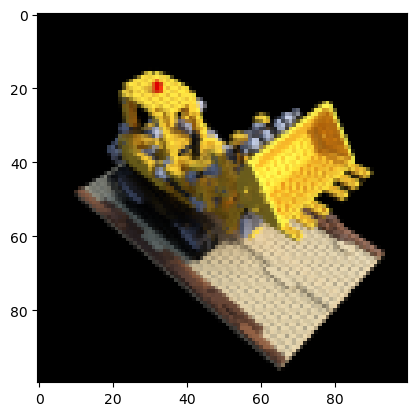

In [42]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

def get_rays(H, W, focal, c2w):
    """
    Get ray origin, direction to each image pixels based on camera pose
    """
    def meshgrid_xy(tensor1, tensor2):
        i, j = torch.meshgrid(tensor1, tensor2, indexing="ij")
        return i.transpose(-1, -2), j.transpose(-1, -2)
    
    i, j = meshgrid_xy(
        torch.arange(W, dtype=torch.float32).to(device),
        torch.arange(H, dtype=torch.float32).to(device)
    )
    dirs = torch.stack([(i-W*0.5)/focal, -(j-H*0.5)/focal, -torch.ones_like(i)], dim=-1).to(device)
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], dim=-1)
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    return rays_o, rays_d

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

### Delaunay 

In [43]:
num_init_points = 3000
SIZE = 100
primal_points = (torch.rand(num_init_points, 3, device='cuda')-.5)*.05
primal_color = torch.rand_like(primal_points)
primal_density = 10*torch.ones_like(primal_points[:, :1])

triangulation = radfoam.Triangulation(primal_points)
perm = triangulation.permutation().to(torch.long)
primal_points = primal_points[perm]
primal_color = primal_color[perm]
primal_density = primal_density[perm]

primal_points.requires_grad_(True)
primal_color.requires_grad_(True)
primal_density.requires_grad_(True)
print('ok')

def tet_to_tri(tets):
    return torch.cat((tets[:, [0, 2, 1]], tets[:, [0, 1, 3]], tets[:, [0, 3, 2]], tets[:, [2, 3, 1]]), dim=0)

faces = tet_to_tri(triangulation.tets().long())
mesh = Meshes(verts=primal_points.unsqueeze(0), faces=faces.unsqueeze(0))

ok


In [44]:

def interpret_blender_cameras(
    pose_target: torch.Tensor, focal: float):
    """
    Convert 4x4 matrices representing cameras in blender format
    to PyTorch3D format.

    Args:
        poses: N x 3 x 4 camera matrices
        focal: ndc space focal length
    """

    pose_target = pose_target[:3, :4]
    mtx = torch.eye(4, dtype=pose_target.dtype, device=device)
    mtx[:3, :3] = pose_target[:3, :3].t()
    mtx[3, :3] = pose_target[:, 3]
    mtx = mtx.inverse()

    # flip the XZ coordinates.
    mtx[:, [0, 2]] *= -1.0

    Rpt3, Tpt3 = mtx[:, :3].split([3, 1], dim=0)

    focal_length_pt3 = torch.tensor([[focal, focal]], device=device, dtype=torch.float32)
    principal_point_pt3 = torch.tensor([[0.0, 0.0]], device=device, dtype=torch.float32)

    cameras = PerspectiveCameras(
        focal_length=focal_length_pt3,
        principal_point=principal_point_pt3,
        R=Rpt3[None],
        T=Tpt3,
        device=device
    )
    return cameras

In [45]:
def py3d_rasterizer(c2w, focal):
    cameras = interpret_blender_cameras(c2w, focal)
    raster_settings = RasterizationSettings(
    image_size=SIZE,
    blur_radius=0.0,
    faces_per_pixel=150
    )
    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
    return rasterizer

In [46]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

images = torch.from_numpy(images).to(device).to(torch.float32)
poses = torch.from_numpy(poses).to(device).to(torch.float32)
focal = torch.from_numpy(focal).to(device).to(torch.float32)

H, W = images.shape[1:3]

# Define test set, training set
testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]
rasterizers = [py3d_rasterizer(c,focal) for c in poses]


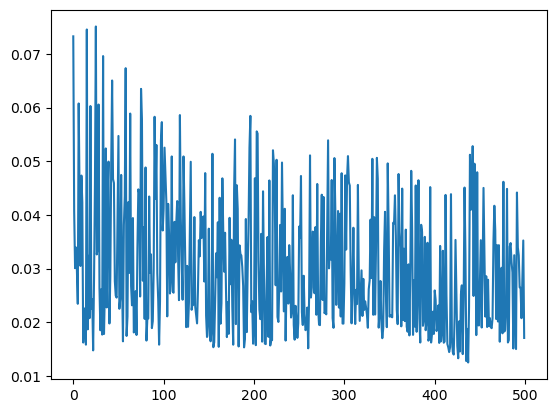

In [47]:
L=[]
optimizer = torch.optim.Adam([
    # {'params': primal_points, 'lr': 1e-4},
    {'params': primal_color, 'lr': 5e-2},
    {'params': primal_density, 'lr': 5e-2}
])
for i in tqdm(range(500)):
    optimizer.zero_grad()
    img_i = np.random.randint(images.shape[0])
    # img_i = 0
    target = images[img_i].to(device)
    pose = poses[img_i].to(device)
    rays_o, rays_d = get_rays(H, W, focal, pose)
    output_colors, weights = rasterize_mesh(rasterizers[img_i], mesh, primal_density, primal_color)
    
    loss = ((output_colors.squeeze()-target)**2).mean()
    L.append(loss.item())
    clear_output(wait=True)
    plt.plot(L)
    plt.show()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        primal_density.clamp_(0, 10000)
        primal_color.clamp_(0, 1)
    # plt.imshow(output_colors.squeeze().cpu().detach().numpy())
    # plt.show()
    # break
    
# plt.imshow(target.cpu().detach().numpy())

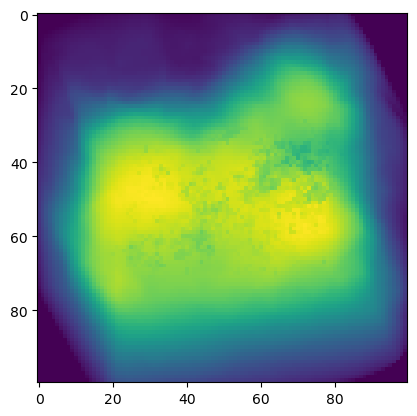

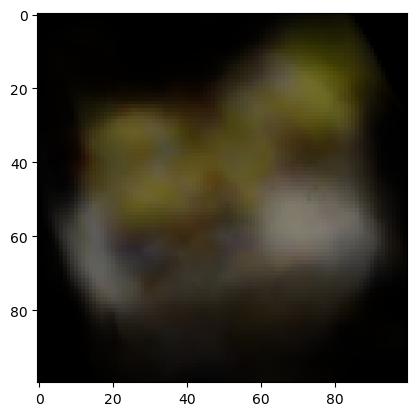

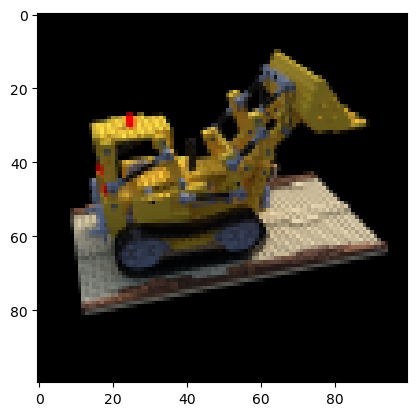

In [49]:
plt.imshow(weights.sum(-1).squeeze().cpu().detach().numpy())
plt.show()
plt.imshow(output_colors.squeeze().cpu().detach().numpy())
plt.show()
plt.imshow(target.cpu().detach().numpy())
plt.show()

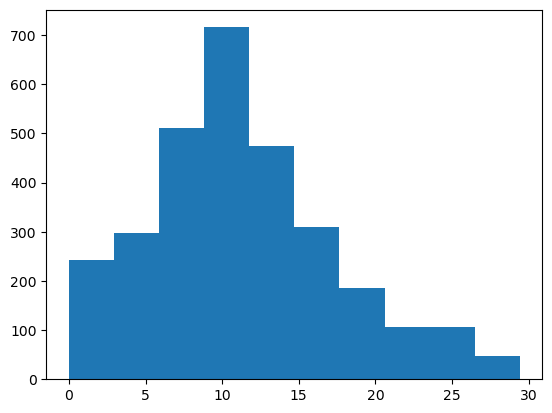

In [50]:
plt.hist(primal_density.cpu().detach().numpy())
plt.show()

In [51]:
v, f, feat = marching_tetrahedra(triangulation.tets().long(), primal_density.squeeze()-15, primal_points, primal_color)

plot(v.cpu().detach().numpy(), f.cpu().detach().numpy(), feat.cpu().detach().numpy())
mt.export_obj(v.cpu().detach().numpy(), f.cpu().detach().numpy(), 'lego.obj')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000736…